# *Library and file dependancies*

In [1]:
# !pip install kneed

*Libraries*

In [2]:
# Single cell 
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ParameterGrid
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 17})
# Output control
import warnings
warnings.filterwarnings("ignore")

*Single cell utility functions*

In [3]:
from utils.plotting import *
from utils.optimization import *
from utils.stats import *

*data file path*

In [4]:
filepath = 'datasets/'

# 1. **Preprocessing**

## **Data formatting** 

The original counts matrix is in txt format, where the columns are cells and the rows are genes. For this reason we load the dataset into a pandas dataframe and:
1. Remove the gene_id and gene_type columns
2. Set the gene name column as the index
3. Transpose the Dataframe

Finally we can load the Dataframe into an AnnData object, readable by scanpy. 

In [5]:
# Pass the txt file into a csv via pandas with tab delimeter
df = pd.read_csv(filepath+"GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt", delimiter="\t")
df.drop(['gene_id','gene_type'], axis = 1, inplace = True)
df.set_index('gene_name', drop=True, inplace=True)
df = df.rename_axis(None)
df  = df.T 
adata = sc.AnnData(df.values)
adata.var_names = df.columns  # Assign column names as feature (gene) names
adata.obs_names = df.index  # Assign row names as observation names (cell or sample names)
adata.var_names_make_unique() # In case of repeatring genes, make the unique
print(adata)
print("\n---------------------\n")
print(adata.obs_names)

AnnData object with n_obs × n_vars = 563 × 57915

---------------------

Index(['BC01_Pooled', 'BC01_Tumor', 'BC02_Pooled', 'BC03_Pooled',
       'BC03LN_Pooled', 'BC04_Pooled', 'BC05_Pooled', 'BC06_Pooled',
       'BC07_Tumor', 'BC07LN_Pooled',
       ...
       'BC11_04', 'BC11_07', 'BC11_28', 'BC11_43', 'BC11_56', 'BC11_69',
       'BC11_70', 'BC11_78', 'BC11_81', 'BC11_88'],
      dtype='object', length=563)


We have a counts matrix with 563 observations and 57915 genes. As you can see in the adata object observation we also have pooled tumour samples. Thus we will seperate the information into two adata objects:
- One for pooled cell counts `padata` 
- One for cell counts `cadata`

In [281]:
# Cell adata 
cadata = adata[14:]
print(f"Cell adata obvervations: {cadata.obs_names}\n")
padata = adata[:14]
print(f"Pool cell adata observations: {padata.obs_names}\n")

Cell adata obvervations: Index(['BC01_02', 'BC01_03', 'BC01_04', 'BC01_05', 'BC01_06', 'BC01_08',
       'BC01_10', 'BC01_11', 'BC01_12', 'BC01_24',
       ...
       'BC11_04', 'BC11_07', 'BC11_28', 'BC11_43', 'BC11_56', 'BC11_69',
       'BC11_70', 'BC11_78', 'BC11_81', 'BC11_88'],
      dtype='object', length=549)

Pool cell adata observations: Index(['BC01_Pooled', 'BC01_Tumor', 'BC02_Pooled', 'BC03_Pooled',
       'BC03LN_Pooled', 'BC04_Pooled', 'BC05_Pooled', 'BC06_Pooled',
       'BC07_Tumor', 'BC07LN_Pooled', 'BC08_Pooled', 'BC09_Pooled',
       'BC10_Pooled', 'BC11_Pooled'],
      dtype='object')



In [ ]:
df = pd.read_csv(filepath+"GSE75688_final_sample_information.txt", delimiter="\t")
df_sorted = df.sort_values(by='sample', ascending=True)
df_sorted = pd.concat([df[df['sample'].str.split('_', expand=True)[1] == 'Pooled'],
                      df[df['sample'].str.split('_', expand=True)[1] != 'Pooled']])

pooled_names = df.loc[df['sample'].str.contains('_Pooled'), 'sample']

mask = df['sample'].isin(pooled_names)

sorted_lines = df[mask].sort_values(by='sample')

df_sorted = pd.concat([sorted_lines, df[~mask]])
df_sorted.loc['BC07_Pooled', "BC07_Tumor"] = 10

bulk_rows = df_sorted[df_sorted['type'] == "Bulk"]
rest_rows = df_sorted[df_sorted['type'] != "Bulk"]

df_sorted.head(25)

Another very important step is to assign each cell population to a tumor group. Cells are named by "BC":PREFIX + "02-11":PATIENT + "_" + "cell number", thus we can remove the specific cell number and only keep the patient tumor identifier "BC02" to "BC011".

In [282]:
tumor_groups_c = [obs_name if "Pooled" in obs_name else obs_name.split("_")[0] for obs_name in cadata.obs_names]
cadata.obs['tumor_groups'] = tumor_groups_c
# For example the first gorup of cells should belong to the tumor of patient one 
cadata.obs['tumor_groups'].head()

BC01_02    BC01
BC01_03    BC01
BC01_04    BC01
BC01_05    BC01
BC01_06    BC01
Name: tumor_groups, dtype: object

## **Quality Control**

For quality control we utilize our own pipeline following single cell best practises, we end up with 518 cells rather than 515 of the Authors.

Before we begin we simply remove genes that have 0 expression across all cells since they can affect heavily the QC process

In [283]:
mask = cadata.X.sum(axis = 0) == 0
cadata = cadata[:,~mask]
padata = padata[:,~mask]
cadata

View of AnnData object with n_obs × n_vars = 549 × 36123
    obs: 'tumor_groups'

In [315]:
# initial_genes = cadata.copy()

cadata = initial_genes.copy()

## *Cell fileting*

As you can see this removed 21.792 genes that were not expressed in any of the cells

We continue with the QC:

To maintain quality control, we follow the best practices by removing cells from our analysis that show certain characteristics. These characteristics include having a small number of detected genes, low count depth, and a high proportion of mitochondrial counts. These traits may suggest that the cell membrane is compromised or that the cell is dead. Since these cells are not the main focus of our analysis and can affect the accuracy of our subsequent analysis, we remove them from our dataset using the three covariates.

  - The number of counts per cell (count depth)

  - The number of genes per cell

  - The fraction of counts from mitochondrial genes per cell <--- However in the context of breast cancer, since cancer cells may have altered mitchondrial pathways, we wont remove cells based on the last covariate

Below we annotate mitochondrial genes:

In [316]:
# mitochondrial genes
cadata.var["mt"] = cadata.var_names.str.startswith("MT-")

Before proceeding with cell & gene filtering we annotate quality control metrics to the counts matrix via scanpy's `calculate_qc_metrics` for the `cadata` counts matrix for the top 20% genes.

In [317]:
sc.pp.calculate_qc_metrics(cadata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)
cadata

AnnData object with n_obs × n_vars = 549 × 36123
    obs: 'tumor_groups', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

- "log1p total counts" refers to the log transformed overall count of all gene expression in a cell.
- The "log1p n genes by counts" value signifies the log transformed number of genes expressed in each cell.
- The "pct_counts_in_top_20_genes" value show the percentage of the total expression in each cell the 20 most expressed genes have.

Regarding the proportion of total counts in a cell that can be attributed to mitochondrial genes, we can see that we have outliers with very high mitochondrial gene expression

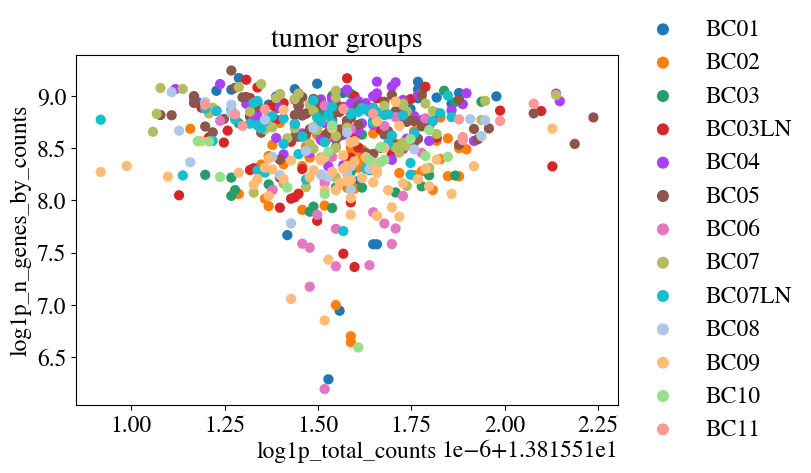

In [318]:
sc.pl.scatter(cadata, y = 'log1p_n_genes_by_counts', x = 'log1p_total_counts', color='tumor_groups') 
# sc.pl.violin(cadata, ['n_genes_by_counts'], save='_n_genes', jitter=1)
# sc.pl.violin(cadata, ['total_counts'], save='_total_counts', jitter=1)



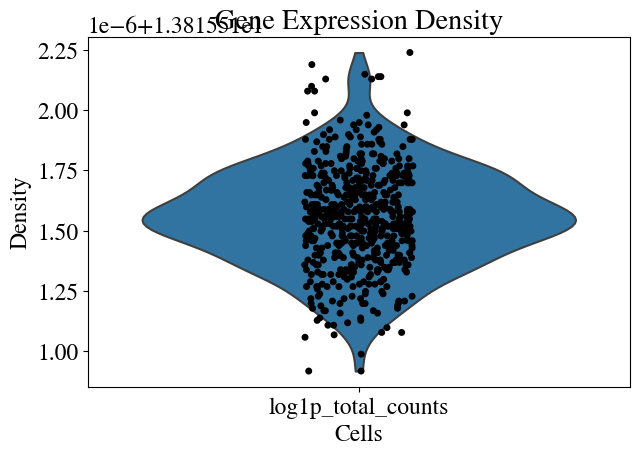

In [319]:
sc.pl.violin(cadata, "log1p_total_counts", show =False, size = 5)
plt.title("Gene Expression Density")
plt.xlabel("Cells")
plt.ylabel("Density")
plt.show()

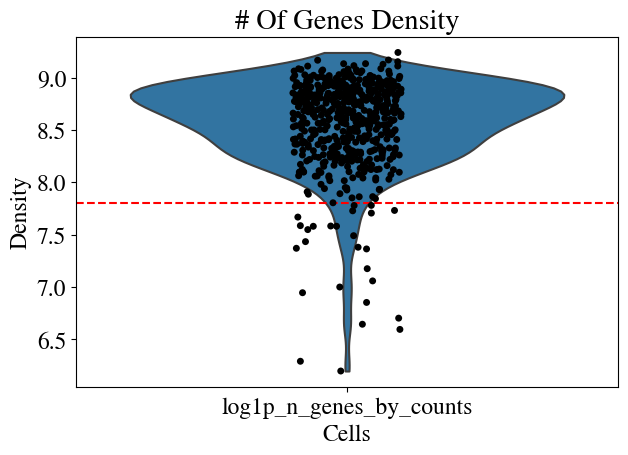

In [320]:
sc.pl.violin(cadata, "log1p_n_genes_by_counts", show =False, size = 5)
plt.title("# Of Genes Density")
plt.xlabel("Cells")
plt.ylabel("Density")
plt.axhline(y=7.8, color='red', linestyle='--')

plt.show()

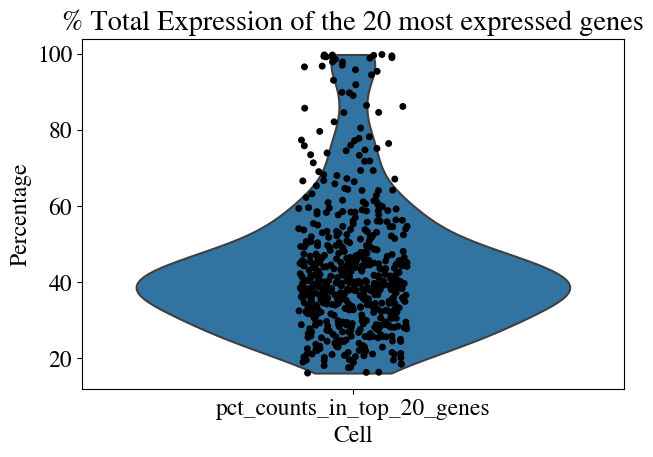

In [321]:
sc.pl.violin(cadata, "pct_counts_in_top_20_genes", show =False, size = 5)
plt.title("% Total Expression of the 20 most expressed genes")
plt.xlabel("Cell")
plt.ylabel("Percentage")
plt.show()

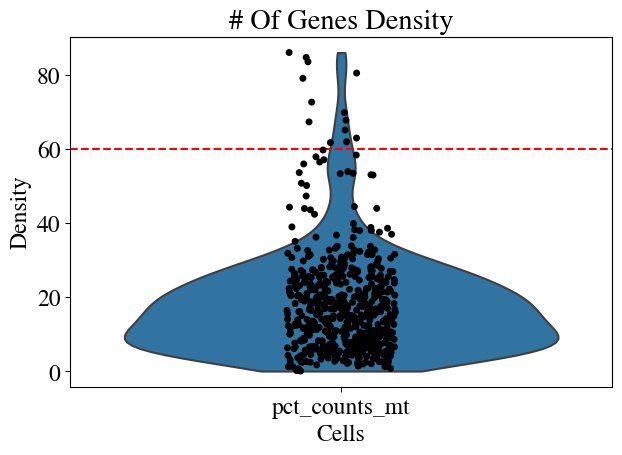

In [322]:
sc.pl.violin(cadata, "pct_counts_mt", show =False, size = 5)
plt.title("# Of Genes Density")
plt.xlabel("Cells")
plt.ylabel("Density")
plt.axhline(y=60, color='red', linestyle='--')

plt.show()

Based on the above, we remove cells that are located 5 absolute deviations from the median in any of the above distributions.
$$ MAD = median(|X_i - median(X))$$


In [323]:
# cadata[(cadata.obs.log1p_n_genes_by_counts > 7.8) &
# (cadata.obs.pct_counts_mt < 60) ,:].shape
# (cadata.obs.pct_counts_mt < 65),:].shape

# cadata = cadata[(cadata.obs.log1p_total_counts_mt > 9.7) & 
# (cadata.obs.log1p_n_genes_by_counts > 7.7) &
# (cadata.obs.pct_counts_mt < 65),:]

In [326]:
cadata.obs["outlier"] = (
    is_outlier(cadata, "log1p_total_counts", 5)
    | is_outlier(cadata, "log1p_n_genes_by_counts", 5)
    | is_outlier(cadata, "pct_counts_in_top_20_genes", 5)
)
cadata.obs.outlier.value_counts()

False    518
True      31
Name: outlier, dtype: int64

In [327]:
cadata = cadata[~cadata.obs.outlier]

In [328]:
# Convert "sample" column to a list
sample_values = rest_rows["sample"].tolist()

# Check if each value from cadata.obs_names is present in sample_values
is_present = cadata.obs_names.isin(sample_values)
count_true = is_present.sum()

# Print the result
print(count_true)

509


## Same for Padata ##

In [286]:
padata.var["mt"] = padata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(padata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)
padata

AnnData object with n_obs × n_vars = 14 × 36123
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [334]:
padata.obs["outlier"] = (
     is_outlier(padata, "log1p_n_genes_by_counts", 5)
)
padata.obs.outlier.value_counts()

False    13
True      1
Name: outlier, dtype: int64

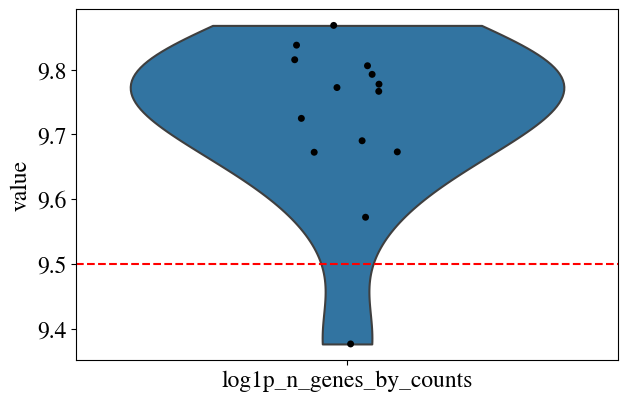

In [333]:
sc.pl.violin(padata, "log1p_n_genes_by_counts", show =False, size = 5)
plt.axhline(y=9.5, color='red', linestyle='--')

In [335]:
padata = padata[~padata.obs.outlier]
padata.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,outlier
BC01_Pooled,16160,9.690356,999815.27,13.815327,31.350661,253264.04,12.442192,25.331083,False
BC01_Tumor,16727,9.724839,994392.74,13.809889,52.571495,394148.53,12.884486,39.637109,False
BC02_Pooled,17541,9.772353,999518.53,13.815030,22.945756,142991.11,11.870545,14.305999,False
BC03LN_Pooled,14363,9.572480,999524.69,13.815036,22.260332,77475.74,11.257733,7.751258,False
BC04_Pooled,15885,9.673193,999673.50,13.815185,28.173970,191777.46,12.164096,19.184010,False
BC05_Pooled,18140,9.805930,999237.16,13.814748,29.914108,179673.53,12.098902,17.981070,False
BC06_Pooled,17632,9.777527,998540.14,13.814051,19.337283,58059.90,10.969248,5.814478,False
BC07_Tumor,18725,9.837668,995785.15,13.811288,29.268348,141427.01,11.859546,14.202563,False
BC07LN_Pooled,15876,9.672627,999650.86,13.815162,20.599417,107263.44,11.583052,10.730090,False
BC08_Pooled,19304,9.868119,998780.25,13.814291,28.686380,159928.66,11.982489,16.012397,False


## *Gene Filtering*

In [92]:
cadata

View of AnnData object with n_obs × n_vars = 516 × 36123
    obs: 'tumor_groups', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

For gene filtering we follow the authors workflow and:
1. Set to 0 genes with counts < 1.
2. Remove genes that are expressed in less than 10% of all tumour groups. Below is an example of tumour expression for 10 of the total 36123 genes

In [93]:
# 1. 
cadata.X[cadata.X < 1] = 0

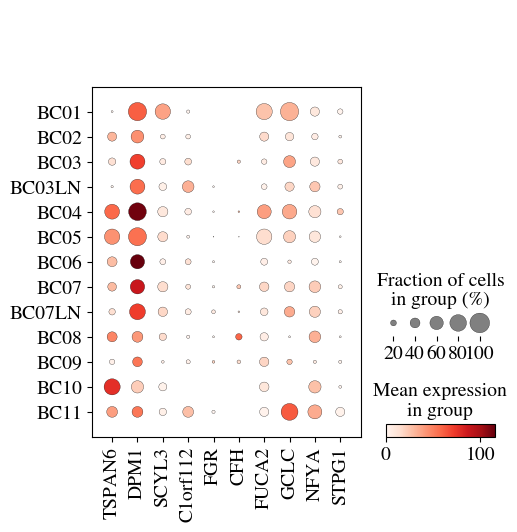

In [94]:
sc.pl.dotplot(cadata,cadata.var_names[:10],groupby="tumor_groups")

Now we can filter out all the genes expressed in 10% of all tumour groups.

In [95]:
df_expression = pd.DataFrame(data=cadata.X, columns=cadata.var_names)
df_expression['tumor_groups'] = cadata.obs['tumor_groups'].values

# Group by tumor groups and sum the expression values for cells in the group
group = df_expression.groupby("tumor_groups").sum() 
# Make expression binary
group[group > 0] = 1
mask = group.sum(axis = 0) < 0.1 * group.shape[0] 
cadata = cadata[:,~mask]
padata = padata[:,~mask]
cadata

View of AnnData object with n_obs × n_vars = 516 × 27657
    obs: 'tumor_groups', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

Finally we can perform log transformation and normalization

In [96]:
cadata.X

ArrayView([[0.0000000e+00, 5.0730000e+01, 3.2800000e+00, ...,
            0.0000000e+00, 1.8414340e+04, 5.3711000e+02],
           [0.0000000e+00, 1.2046000e+02, 0.0000000e+00, ...,
            0.0000000e+00, 1.9603440e+04, 6.5327000e+02],
           [0.0000000e+00, 6.9700000e+00, 9.2230000e+01, ...,
            0.0000000e+00, 2.8523940e+04, 9.1642000e+02],
           ...,
           [0.0000000e+00, 1.3607000e+02, 0.0000000e+00, ...,
            0.0000000e+00, 3.3465110e+04, 1.6521900e+03],
           [2.0082000e+02, 2.2030000e+01, 0.0000000e+00, ...,
            0.0000000e+00, 1.0890135e+05, 3.4395300e+03],
           [0.0000000e+00, 2.0458000e+02, 9.5200000e+00, ...,
            0.0000000e+00, 5.7492010e+04, 1.8374100e+03]])

In [97]:
sc.pp.normalize_total(cadata)
sc.pp.log1p(cadata, base = 2)

sc.pp.normalize_total(padata)
sc.pp.log1p(padata, base = 2)

We obtained 27,000 genes out of the 57,000 total, which is higher than the 17,000 genes reported by the authors.

In [98]:
padata

AnnData object with n_obs × n_vars = 14 × 27657
    uns: 'log1p'

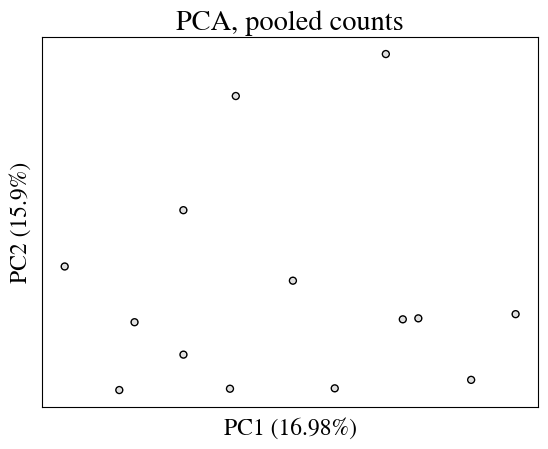

In [99]:
sc.pp.pca(padata)
sc.pl.pca(padata,annotate_var_explained = True, title = "PCA, pooled counts",add_outline=True, size = 50,palette = "tab20")

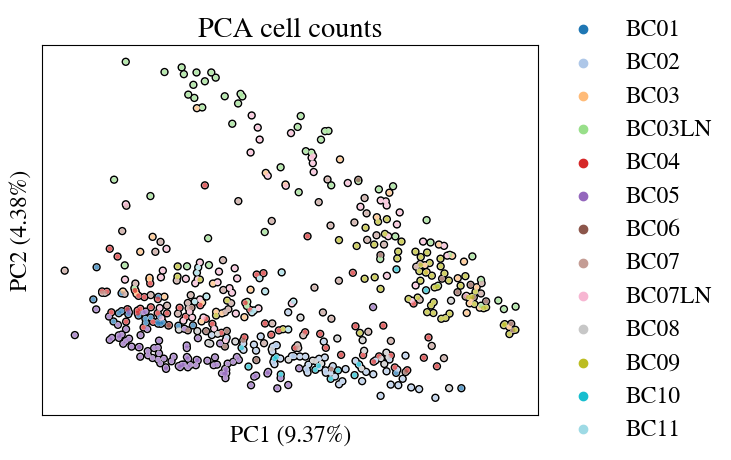

In [100]:
sc.pp.pca(cadata)
sc.pl.pca(cadata, color = "tumor_groups",annotate_var_explained = True, title = "PCA cell counts",add_outline=True, size = 50,palette = "tab20")

# Save the processed adata objects

In [26]:
adata.write("datasets/processed_cellcounts.h5ad")
adata.write("datasets/processed_pooledcounts.h5ad")

## Labeled Cells ##

## UMAP ###

2023-06-17 19:44:04.121125: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-17 19:44:04.273256: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-17 19:44:04.924179: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-17 19:44:04.924229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

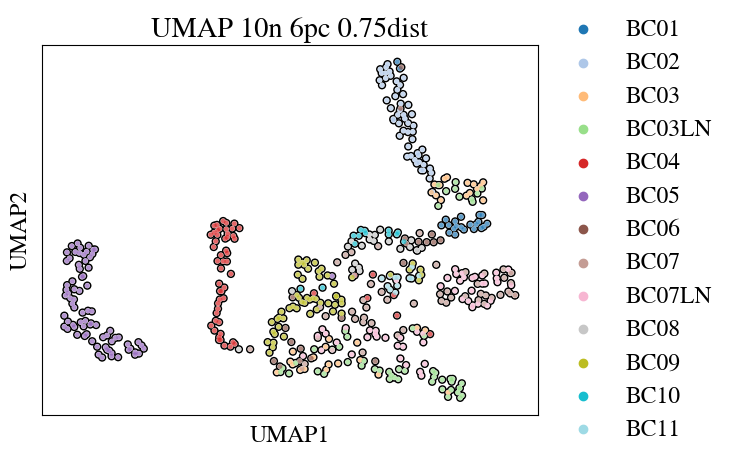

In [27]:
umap_adata = cadata.copy()

# param_grid_nei = {'n_pcs': [2,3,4,5,6,7,8,9,10],'use_rep':[None],
#         'n_neighbors': [10,15,20,25,30,35,40]}
# param_grid_umap = {'min_dist':[0.25,0.5,0.75], 'random_state':[0]}

# for params in ParameterGrid(param_grid_nei):
#   for params_umap in ParameterGrid(param_grid_umap):
#     sc.pp.neighbors(umap_adata, **params)
#     sc.tl.umap(umap_adata,**params_umap)
#     title ='UMAP'+'_'+  str(params['n_neighbors'])+'_'+  str(params['n_pcs'])+'_'+ str(params_umap['min_dist'])
#     sc.pl.umap(umap_adata, color="tumor_groups", title=title)

sc.pp.neighbors(umap_adata, n_pcs=6, n_neighbors=10)
sc.tl.umap(umap_adata,min_dist=0.75, random_state=0 )
sc.pl.umap(umap_adata, color="tumor_groups", title='UMAP 10n 6pc 0.75dist', add_outline=True, size = 50,palette = "tab20")


## t-SNE ##

In [28]:
def tsne_params(datasize):
  n = datasize/100
  if n/100 > 30:
    perplexity = 30 + n/100 
  else:
    perplexity = 30
  if datasize/12 > 200:
    learning_rate = datasize/12
  else:
    learning_rate = 200
  return learning_rate, perplexity

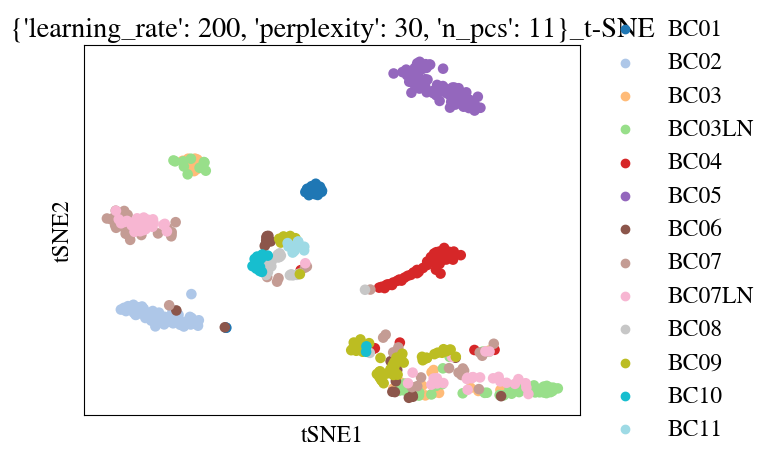

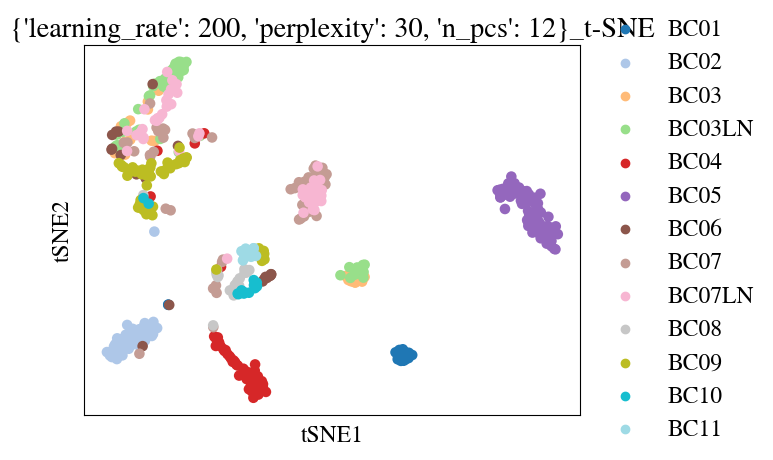

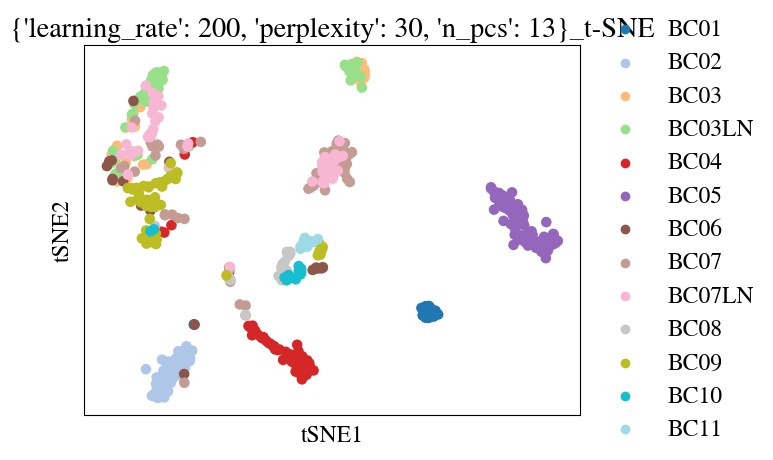

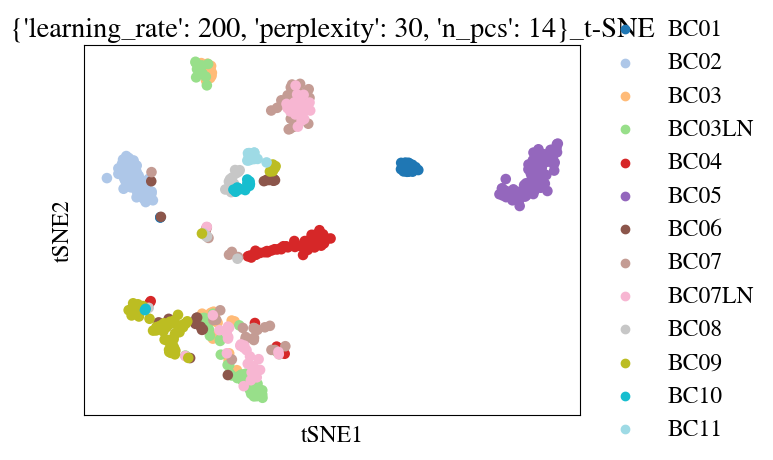

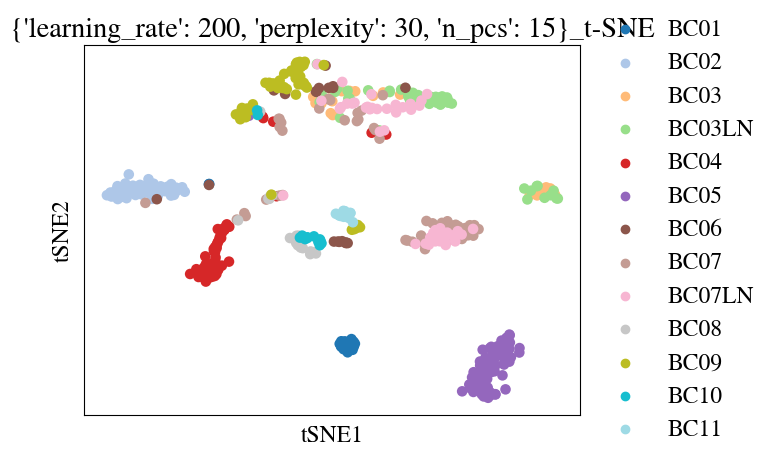

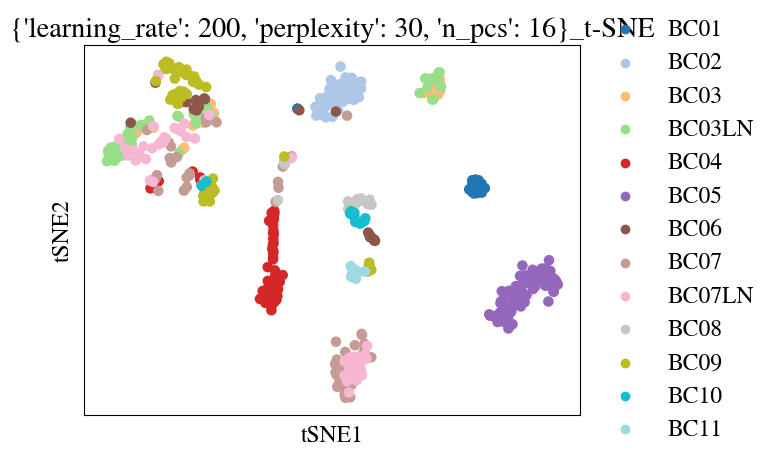

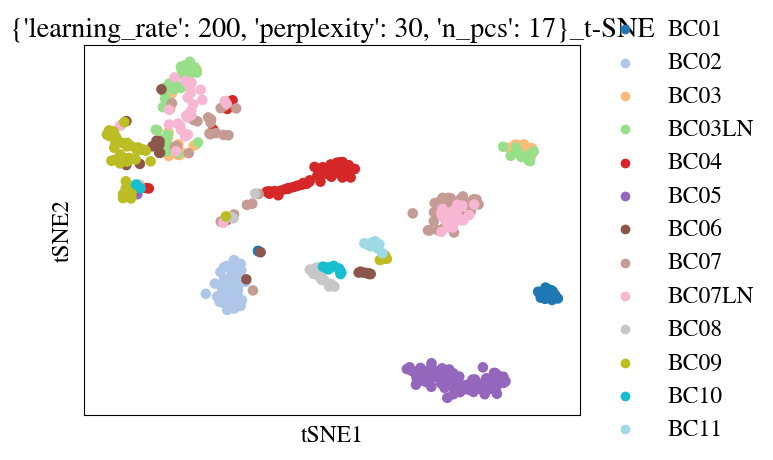

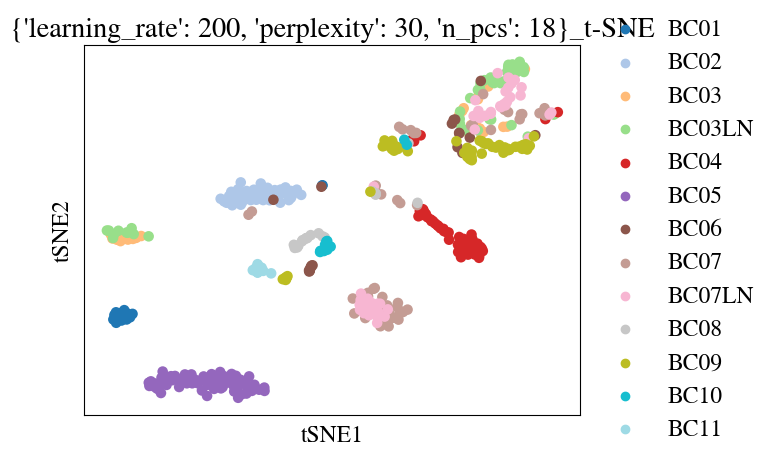

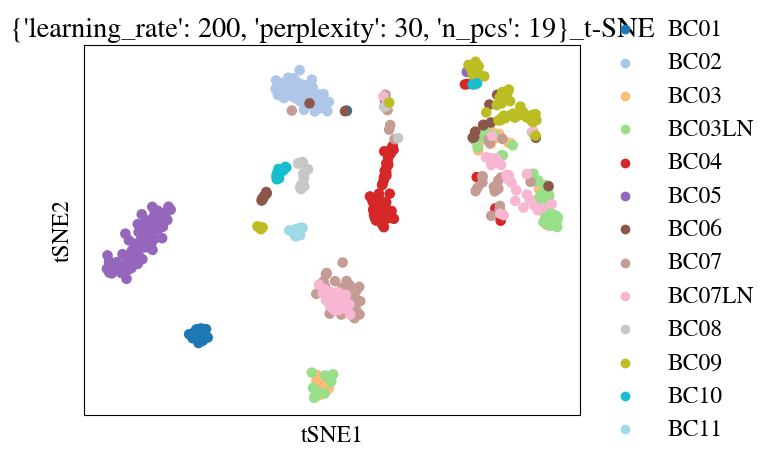

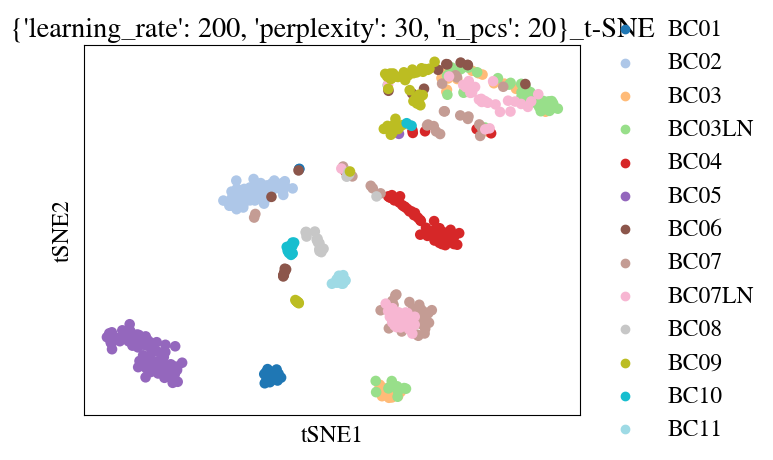

In [29]:
tsne_adata = umap_adata.copy()

lr, perpl = tsne_params(umap_adata.X.shape[0])
n_pcs=[11,12,13,14,15,16,17,18,19,20]

for par in n_pcs:
    params = {'learning_rate': lr, 'perplexity': perpl, 'n_pcs': par}
    sc.tl.tsne(tsne_adata, **params)
    title = str(params) + '_t-SNE'
    sc.pl.tsne(tsne_adata, color="tumor_groups", title=title)#, add_outline=True, size=50, palette="tab20")


# το αφηνω ετσι για να διαλεξουμε, για εμενα αυτα με τους 11,12, 14 κομπονεντσ ειναι τα καλυτερα

In [30]:
umap_adata.X.shape[1]

27664

## Separation of Carcinoma and non Carcinoma cells 

In [31]:
cadata

AnnData object with n_obs × n_vars = 518 × 27664
    obs: 'tumor_groups', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'pca', 'tumor_groups_colors'
    obsm: 'X_pca'
    varm: 'PCs'

In [32]:
# import requests

# # Define the URL
# url = "https://gtexportal.org/api/v2/expression/geneExpression"

# # Define the parameters
# params = {
#     "gencodeId": ['ENSG00000000003.14'],
#     "datasetId": "gtex_v8",
#     "tissueSiteDetailId": ["Breast_Mammary_Tissue"],  # Specify the tissue IDs you are interested in
#     "page": 0,
#     "itemsPerPage": 250
# }

# response = requests.get(url, params=params)

# # Check the response status code
# if response.status_code == 200:
#     gene_expression_data = response.json()
# else:
#     print("Error: Failed to retrieve gene expression data. Status code:", response.status_code)


In [33]:
adata_orig = sc.read_h5ad('GTEx_8_tissues_snRNAseq_atlas_071421.public_obs.h5ad')

In [34]:
adata_orig

AnnData object with n_obs × n_vars = 209126 × 17695
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', 'gene_biotype', 'gene_length', 'gene_coding_length', 'Approved symbol', '

In [35]:
# Filter adata_orig based on 'Breast - Mammary Tissue'
filtered_adata = adata_orig[adata_orig.obs['Tissue Site Detail'] == 'Breast - Mammary Tissue'].copy()

# Reset the index of the filtered_adata
filtered_adata.obs = filtered_adata.obs.reset_index(drop=True)

In [36]:
filtered_adata

AnnData object with n_obs × n_vars = 9770 × 17695
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', 'gene_biotype', 'gene_length', 'gene_coding_length', 'Approved symbol', 'Ap